In [ ]:
!pip3 install git+https://github.com/zalandoresearch/flair

In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

True

> ## Create a Corpus

### 1) Load from simple CSV file

In [ ]:
from flair.datasets import CSVClassificationCorpus

Great development..

### 2) FastText Format

In [ ]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [ ]:
FILE_PATH = "bbc-text.csv"
DATASET_FOLDER_PATH = os.path.join("splitted_data", FILE_PATH.split(".")[0])

column_name = {
    "text": "text",
    "label": "category"
}

# file format
__label__<label_1> <text>
__label__<label_1> __label__<label_2> <text>

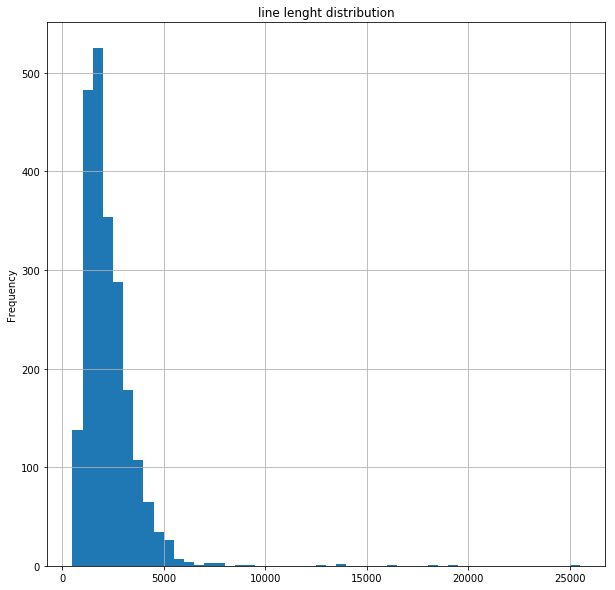

In [7]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

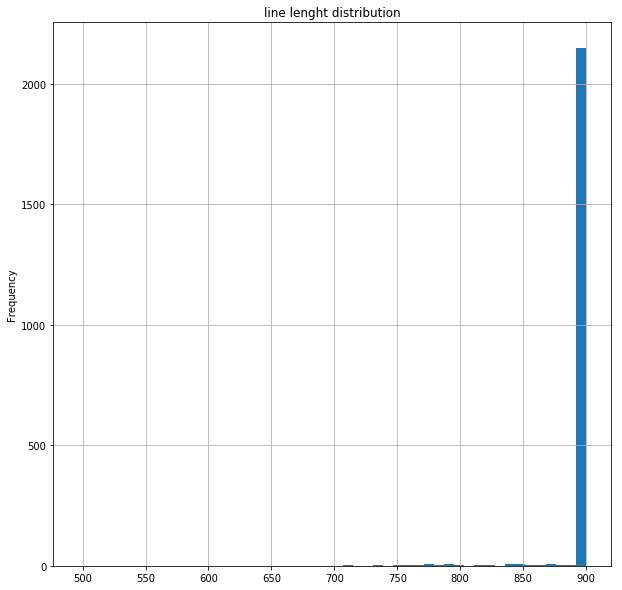

In [17]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = clear_text(data_df["text"])
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:900])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [ ]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [19]:
corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-11 16:06:53,206 Reading data from splitted_data/bbc-text
2019-08-11 16:06:53,207 Train: splitted_data/bbc-text/train.csv
2019-08-11 16:06:53,208 Dev: splitted_data/bbc-text/dev.csv
2019-08-11 16:06:53,209 Test: splitted_data/bbc-text/test.csv


Each line in a corpus is converted to a Sentence object annotated with the labels.

## Check distribution

In [20]:
train_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "train.csv"), names=["label", "text"], delimiter="\t")
train_df.label.value_counts()

__label__business         412
__label__sport            411
__label__politics         333
__label__tech             317
__label__entertainment    307
Name: label, dtype: int64

In [22]:
val_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "dev.csv"), names=["label", "text"], delimiter="\t")
val_df.label.value_counts()

__label__sport            50
__label__business         46
__label__tech             45
__label__politics         42
__label__entertainment    39
Name: label, dtype: int64

In [21]:
test_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "test.csv"), names=["label", "text"], delimiter="\t")
test_df.label.value_counts()

__label__business         52
__label__sport            50
__label__politics         42
__label__entertainment    40
__label__tech             39
Name: label, dtype: int64

## Training a Model

## RoBERTa

In [ ]:
from flair.embeddings import RoBERTaEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
# from flair.visual.training_curves import Plotter

In [ ]:
MODEL_FOLDER_PATH = "model/RoBERTa"
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

In [30]:
params_train = {
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 20,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

word_embeddings = [RoBERTaEmbeddings(), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master


loading archive file http://dl.fbaipublicfiles.com/fairseq/models/roberta.large.tar.gz from cache at /root/.cache/torch/pytorch_fairseq/83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2
| dictionary: 50264 types
2019-08-11 16:26:51,602 Computing label dictionary. Progress:


100%|██████████| 1780/1780 [00:07<00:00, 250.76it/s]

2019-08-11 16:26:59,271 [b'tech', b'sport', b'business', b'entertainment', b'politics']


In [ ]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

In [31]:
trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"], learning_rate=0.01)

2019-08-11 16:27:14,430 ----------------------------------------------------------------------------------------------------
2019-08-11 16:27:14,434 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): RoBERTaEmbeddings(
        (model): RobertaHubInterface(
          (model): RobertaModel(
            (decoder): RobertaEncoder(
              (sentence_encoder): TransformerSentenceEncoder(
                (embed_tokens): Embedding(50265, 1024, padding_idx=1)
                (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
                (layers): ModuleList(
                  (0): TransformerSentenceEncoderLayer(
                    (self_attn): MultiheadAttention(
                      (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    )
                    (self_attn_layer_norm): LayerNorm(torch.Size([1024]), eps=1e-05, elementwise_affine=True)

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master


loading archive file http://dl.fbaipublicfiles.com/fairseq/models/roberta.large.tar.gz from cache at /root/.cache/torch/pytorch_fairseq/83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2
| dictionary: 50264 types
2019-08-11 17:30:36,700 0.7668	0.7668	0.7668
2019-08-11 17:30:36,703 
MICRO_AVG: acc 0.6218 - f1-score 0.7668
MACRO_AVG: acc 0.6285 - f1-score 0.76726
business   tp: 44 - fp: 26 - fn: 8 - tn: 145 - precision: 0.6286 - recall: 0.8462 - accuracy: 0.5641 - f1-score: 0.7213
entertainment tp: 32 - fp: 5 - fn: 8 - tn: 178 - precision: 0.8649 - recall: 0.8000 - accuracy: 0.7111 - f1-score: 0.8312
politics   tp: 24 - fp: 8 - fn: 18 - tn: 173 - precision: 0.7500 - recall: 0.5714 - accuracy: 0.4800 - f1-score: 0.6486
sport      tp: 40 - fp: 3 - fn: 10 - tn: 170 - precision: 0.9302 - recall: 0.8000 - accuracy: 0.7547 - f1-score: 0.8602
tech       tp: 31 - fp: 10 - fn: 8 - tn: 174 - precision: 0.7561 - recall: 

{'test_score': 0.7668,
 'dev_score_history': [0.2568,
  0.3243,
  0.3063,
  0.4099,
  0.7432,
  0.473,
  0.5541,
  0.6802,
  0.6216,
  0.6937,
  0.518,
  0.7703,
  0.7297,
  0.7748,
  0.7117,
  0.7342,
  0.5991,
  0.7117,
  0.7703,
  0.7613],
 'train_loss_history': [1.6650560923985072,
  1.579370447567531,
  1.5145624769585473,
  1.4468005022832326,
  1.3857062309980392,
  1.3338194681065423,
  1.2596337177923747,
  1.2002403001700128,
  1.1352317386439867,
  1.0285237495388304,
  0.9777749595897538,
  0.9501529633998871,
  0.9055893974644798,
  0.8803673216274807,
  0.839250705071858,
  0.8151753076485225,
  0.7789160971130643,
  0.7602949142456055,
  0.7133464312979153,
  0.6982290931046009],
 'dev_loss_history': [tensor(1.5684, device='cuda:0'),
  tensor(1.4986, device='cuda:0'),
  tensor(1.5374, device='cuda:0'),
  tensor(1.3849, device='cuda:0'),
  tensor(1.2901, device='cuda:0'),
  tensor(1.2750, device='cuda:0'),
  tensor(1.2241, device='cuda:0'),
  tensor(1.1572, device='cuda:0

## Plot training curves

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(MODEL_FOLDER_PATH, 'loss.tsv'))
plotter.plot_weights(os.path.join(MODEL_FOLDER_PATH, 'weights.txt'))